# N-BEATSx

In [1]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import os
import torch
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNBEATSx, AutoLSTM
from neuralforecast.models import NBEATSx, LSTM, MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, r2_score, f1_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

TRAIN_TEST_RATIO = 0.9
TRAIN_NUM = 2000
TEST_NUM = 500
TARGET_DATA = "IF00"

In [3]:
def load_n(directory: str, time_min = None, time_max=None):
    sheet_dict = pd.read_excel(directory, sheet_name=None, engine='openpyxl')
    combined_df = pd.DataFrame()
    for sheet_name, df in sheet_dict.items():
        df['unique_id'] = df.columns.values[0]
        df.columns.values[0] = 'Time'
        combined_df = combined_df._append(df, ignore_index=True)
    combined_df = combined_df[['unique_id'] + [col for col in combined_df.columns if col != 'unique_id']]
    # new_column_names = ['unique_id', 'ds', 'KPJ', 'y', 'QKPJ', 'ZGJ', 'ZDJ', 'ZDF', 'CJL', 'CJE']
    # for predict 收盘价, 那么y就是 SPJ
    new_column_names = ['unique_id', 'ds', 'KPJ', 'y', 'QSPJ', 'ZGJ', 'ZDJ', 'ZDF', 'CJL', 'CJE']
    combined_df = combined_df.rename(columns=dict(zip(combined_df.columns, new_column_names)))
    arr = combined_df.filter(items=['unique_id', 'ds', 'y', 'KPJ', 'QSPJ', 'ZGJ', 'ZDJ', 'CJL', 'CJE'])

    if time_min is None and time_max is None: # 为了能够选择时间
        return arr
    else:
        return arr[time_min<arr['ds']<time_max].reset_index(drop=True)

def load_groups_n():
    csv_dir_path = './tmp'
    #csv_dir_path = './tmp'
    X = []
    "load the data in a dir which contains multiple csv"
    for file in os.listdir(csv_dir_path):
        if file.endswith('.xlsx'):
            X_df= load_n(os.path.join(csv_dir_path, file))
            X.append(X_df)
    X = pd.concat(X).sort_values(['unique_id', 'ds']).reset_index(drop=True)
    return X

def calculate_evaluation(y_test, y_pred):
    mse = mean_squared_error(y_true=y_test.to_numpy().reshape(-1), y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test.to_numpy().reshape(-1), y_pred=y_pred)
    print(f"Mean Squared Error: {mse}, Mean Absolute Error: {mae}")

    r2 = r2_score(y_test, y_pred)
    print(f"r2 score: {r2}")

    def calculate_mape(y_true, y_pred):
        percentage_errors = [(abs(true - pred) / true) * 100 for true, pred in zip(y_true, y_pred)]
        mape = np.mean(percentage_errors)
        return mape
    mape = calculate_mape(y_test, y_pred)
    print("MAPE:", mape)

    rmse = np.sqrt(((y_test.to_numpy().reshape(-1) - y_pred.to_numpy().reshape(-1)) ** 2).mean())
    print("RMSE:", rmse)

In [4]:
X = load_groups_n()
X_cur = X[X['unique_id']==TARGET_DATA].reset_index(drop=True)
print(X)
print(len(X))

     unique_id         ds       y     KPJ    QSPJ     ZGJ     ZDJ     CJL  \
0         IF00 2010-04-16  3415.6  3450.0  3415.0  3488.0  3413.2   48988   
1         IF00 2010-04-19  3197.4  3396.0  3415.6  3398.0  3166.2  109733   
2         IF00 2010-04-20  3214.6  3209.2  3197.4  3240.0  3168.8  141862   
3         IF00 2010-04-21  3267.2  3215.0  3214.6  3281.2  3208.0  114531   
4         IF00 2010-04-22  3236.2  3260.2  3267.2  3274.4  3211.0  133247   
...        ...        ...     ...     ...     ...     ...     ...     ...   
3195      IF00 2023-06-09  3832.8  3819.6  3811.0  3836.0  3808.4   56763   
3196      IF00 2023-06-12  3833.6  3820.4  3832.8  3858.0  3812.8   64722   
3197      IF00 2023-06-13  3862.6  3829.0  3833.6  3868.0  3828.0   60923   
3198      IF00 2023-06-14  3860.6  3870.6  3862.6  3889.2  3858.2   60143   
3199      IF00 2023-06-15  3924.2  3873.0  3860.6  3925.8  3868.4   49804   

              CJE  
0      505.388053  
1     1082.064122  
2     1363.4209

In [5]:
CPI_file_path = "/home/arthur/Time_Series_Forecasting/HGJJ/1 CPI_PPI（月度数据）.xlsx"
GDP_file_path = "/home/arthur/Time_Series_Forecasting/HGJJ/2 全国GDP（季度数据）.xlsx"

def add_macro_economy_data(X, CPI_file_path, GDP_file_path, use_linear_transform = False):
    data_1 = pd.read_excel(CPI_file_path)
    data_1 = data_1.rename(columns=dict(zip(data_1.columns, ['ds', 'CPI', 'PPI'])))
    data_2 = pd.read_excel(GDP_file_path)
    data_2 = data_2.rename(columns=dict(zip(data_2.columns, ['ds', 'GDP'])))

    X['GDP'] = None
    merged_ = X.merge(data_1, left_on=X['ds'].dt.to_period('M'), 
                               right_on=data_1['ds'].dt.to_period('M'), how='left')
    
    for index, row in merged_.iterrows():
        daily_date = row['ds_x']
        matching_quarterly_row = data_2[data_2['ds'].dt.to_period('Q') == daily_date.to_period('Q')]
        if not matching_quarterly_row.empty:
            merged_.at[index, 'GDP'] = matching_quarterly_row.iloc[0]['GDP']
    
    merged_ = merged_.filter(items=[ 'unique_id', 'ds_x', 'y', 'KPJ', 'QSPJ', 'ZGJ', 'ZDJ', 'CJL', 'CJE', 'CPI', 'PPI', 'GDP'])
    merged_ = merged_.rename(columns=dict(zip(merged_.columns, [ 'unique_id', 'ds', 'y', 'KPJ', 'QSPJ', 'ZGJ', 'ZDJ', 'CJL', 'CJE', 'CPI', 'PPI', 'GDP'])))
    if not use_linear_transform:
        return merged_
    else:
        to_interpolate_columns = ['CPI', 'PPI', 'GDP']
        for column_ in to_interpolate_columns:
            current_value = None
            for index, value in enumerate(merged_[column_]):
                if current_value != value:
                    current_value = value
                else:
                    merged_[column_][index] = None
            merged_[column_].interpolate(method='linear', inplace=True)
        return merged_

X = add_macro_economy_data(X, CPI_file_path, GDP_file_path, use_linear_transform=False)


In [6]:
# X['y_diff'] = X['y'].diff(1)
# X['KPJ_diff'] = X['KPJ'].diff(1)
# X['QSPJ_diff'] = X['QSPJ'].diff(1)
# X['ZGJ_diff'] = X['ZGJ'].diff(1)
# X['ZDJ_diff'] = X['ZDJ'].diff(1)
# X['CTL_diff'] = X['CJL'].diff(1)
# X['CTE_diff'] = X['CJE'].diff(1)

In [7]:
# 最大最小归一化法
# 创建MinMaxScaler对象
scaler = MinMaxScaler()  #（0，1）
## 创建MinMaxScaler对象，指定feature_range参数为(-1, 1)  #scaler = MinMaxScaler(feature_range=(-1, 1))

# 定义需要归一化的列
columns_to_normalize = ['KPJ', 'QSPJ','ZGJ', 'ZDJ', 'CJL', 'CJE', 'y', 'CPI', 'PPI', 'GDP'] #'KPJ_diff', 'QSPJ_diff', 'ZGJ_diff', 'ZDJ_diff', 'CTL_diff', 'CTE_diff']

# 使用MinMaxScaler进行归一化
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])
X = X.dropna()
# 打印归一化后的数据
print(X)

# X_test = X_cur[TRAIN_NUM:]
# X_train = X_cur[:TRAIN_NUM]
X_train = X[:int(len(X) * TRAIN_TEST_RATIO)]
X_test = X[int(len(X) * TRAIN_TEST_RATIO):]

     unique_id         ds         y       KPJ      QSPJ       ZGJ       ZDJ  \
0         IF00 2010-04-16  0.361885  0.358364  0.361725  0.362749  0.380456   
1         IF00 2010-04-19  0.303515  0.344372  0.361885  0.339251  0.314148   
2         IF00 2010-04-20  0.308116  0.295968  0.303515  0.298000  0.314846   
3         IF00 2010-04-21  0.322187  0.297471  0.308116  0.308757  0.325369   
4         IF00 2010-04-22  0.313894  0.309183  0.322187  0.306981  0.326174   
...        ...        ...       ...       ...       ...       ...       ...   
3195      IF00 2023-06-09  0.473490  0.454136  0.467658  0.453606  0.486550   
3196      IF00 2023-06-12  0.473704  0.454343  0.473490  0.459349  0.487732   
3197      IF00 2023-06-13  0.481462  0.456571  0.473704  0.461960  0.491812   
3198      IF00 2023-06-14  0.480927  0.467351  0.481462  0.467495  0.499919   
3199      IF00 2023-06-15  0.497940  0.467973  0.480927  0.477051  0.502658   

           CJL       CJE       CPI       PPI      G

In [8]:
"""
读数据
"""
INPUT_SIZE = 30
MAX_STEP = 200
model = NBEATSx(h=len(X_test), input_size=INPUT_SIZE,
                #loss=MQLoss(),
                #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                #scaler_type='robust', #dropout_prob_theta=0.5,
                #hist_exog_list=['KPJ', 'QSPJ','ZGJ', 'ZDJ', 'CJL', 'CJE'],
                futr_exog_list=['KPJ', 'QSPJ','ZGJ', 'ZDJ', 'CJL', 'CJE', 'CPI', 'PPI', 'GDP'], #'KPJ_diff', 'QSPJ_diff', 'ZGJ_diff', 'ZDJ_diff', 'CTL_diff', 'CTE_diff'], MAX_STEP = 200
                max_steps=MAX_STEP)

nf1 = NeuralForecast(
    models=[model],
    freq='B'
)


Global seed set to 1


In [9]:
"""
训练和预测
"""
print(X_train)
nf1.fit(df=X_train)

# nf1.save(path='./checkpoints/nbeatsx_run/',
#         model_index=None, 
#         overwrite=True,
#         save_dataset=True)
# nf1 = NeuralForecast.load(path='./checkpoints/nbeatsx_run/')

     unique_id         ds         y       KPJ      QSPJ       ZGJ       ZDJ  \
0         IF00 2010-04-16  0.361885  0.358364  0.361725  0.362749  0.380456   
1         IF00 2010-04-19  0.303515  0.344372  0.361885  0.339251  0.314148   
2         IF00 2010-04-20  0.308116  0.295968  0.303515  0.298000  0.314846   
3         IF00 2010-04-21  0.322187  0.297471  0.308116  0.308757  0.325369   
4         IF00 2010-04-22  0.313894  0.309183  0.322187  0.306981  0.326174   
...        ...        ...       ...       ...       ...       ...       ...   
2875      IF00 2022-02-16  0.682039  0.661277  0.676368  0.663151  0.699597   
2876      IF00 2022-02-17  0.685089  0.659204  0.682039  0.666806  0.699812   
2877      IF00 2022-02-18  0.688460  0.656768  0.685089  0.663412  0.698631   
2878      IF00 2022-02-21  0.686052  0.667081  0.688460  0.664822  0.700403   
2879      IF00 2022-02-22  0.670537  0.654851  0.686052  0.651768  0.683114   

           CJL       CJE       CPI       PPI       

                  ds
unique_id           
IF00      2022-02-23
IF00      2022-02-24
IF00      2022-02-25
IF00      2022-02-28
IF00      2022-03-01
...              ...
IF00      2023-05-10
IF00      2023-05-11
IF00      2023-05-12
IF00      2023-05-15
IF00      2023-05-16

[320 rows x 1 columns]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.33it/s]
                  ds   NBEATSx
unique_id                     
IF00      2022-02-23  0.634708
IF00      2022-02-24  0.624189
IF00      2022-02-25  0.613014
IF00      2022-02-28  0.616935
IF00      2022-03-01  0.622409
...              ...       ...
IF00      2023-05-10  0.524119
IF00      2023-05-11  0.503839
IF00      2023-05-12  0.513044
IF00      2023-05-15  0.516199
IF00      2023-05-16  0.510449

[320 rows x 2 columns]


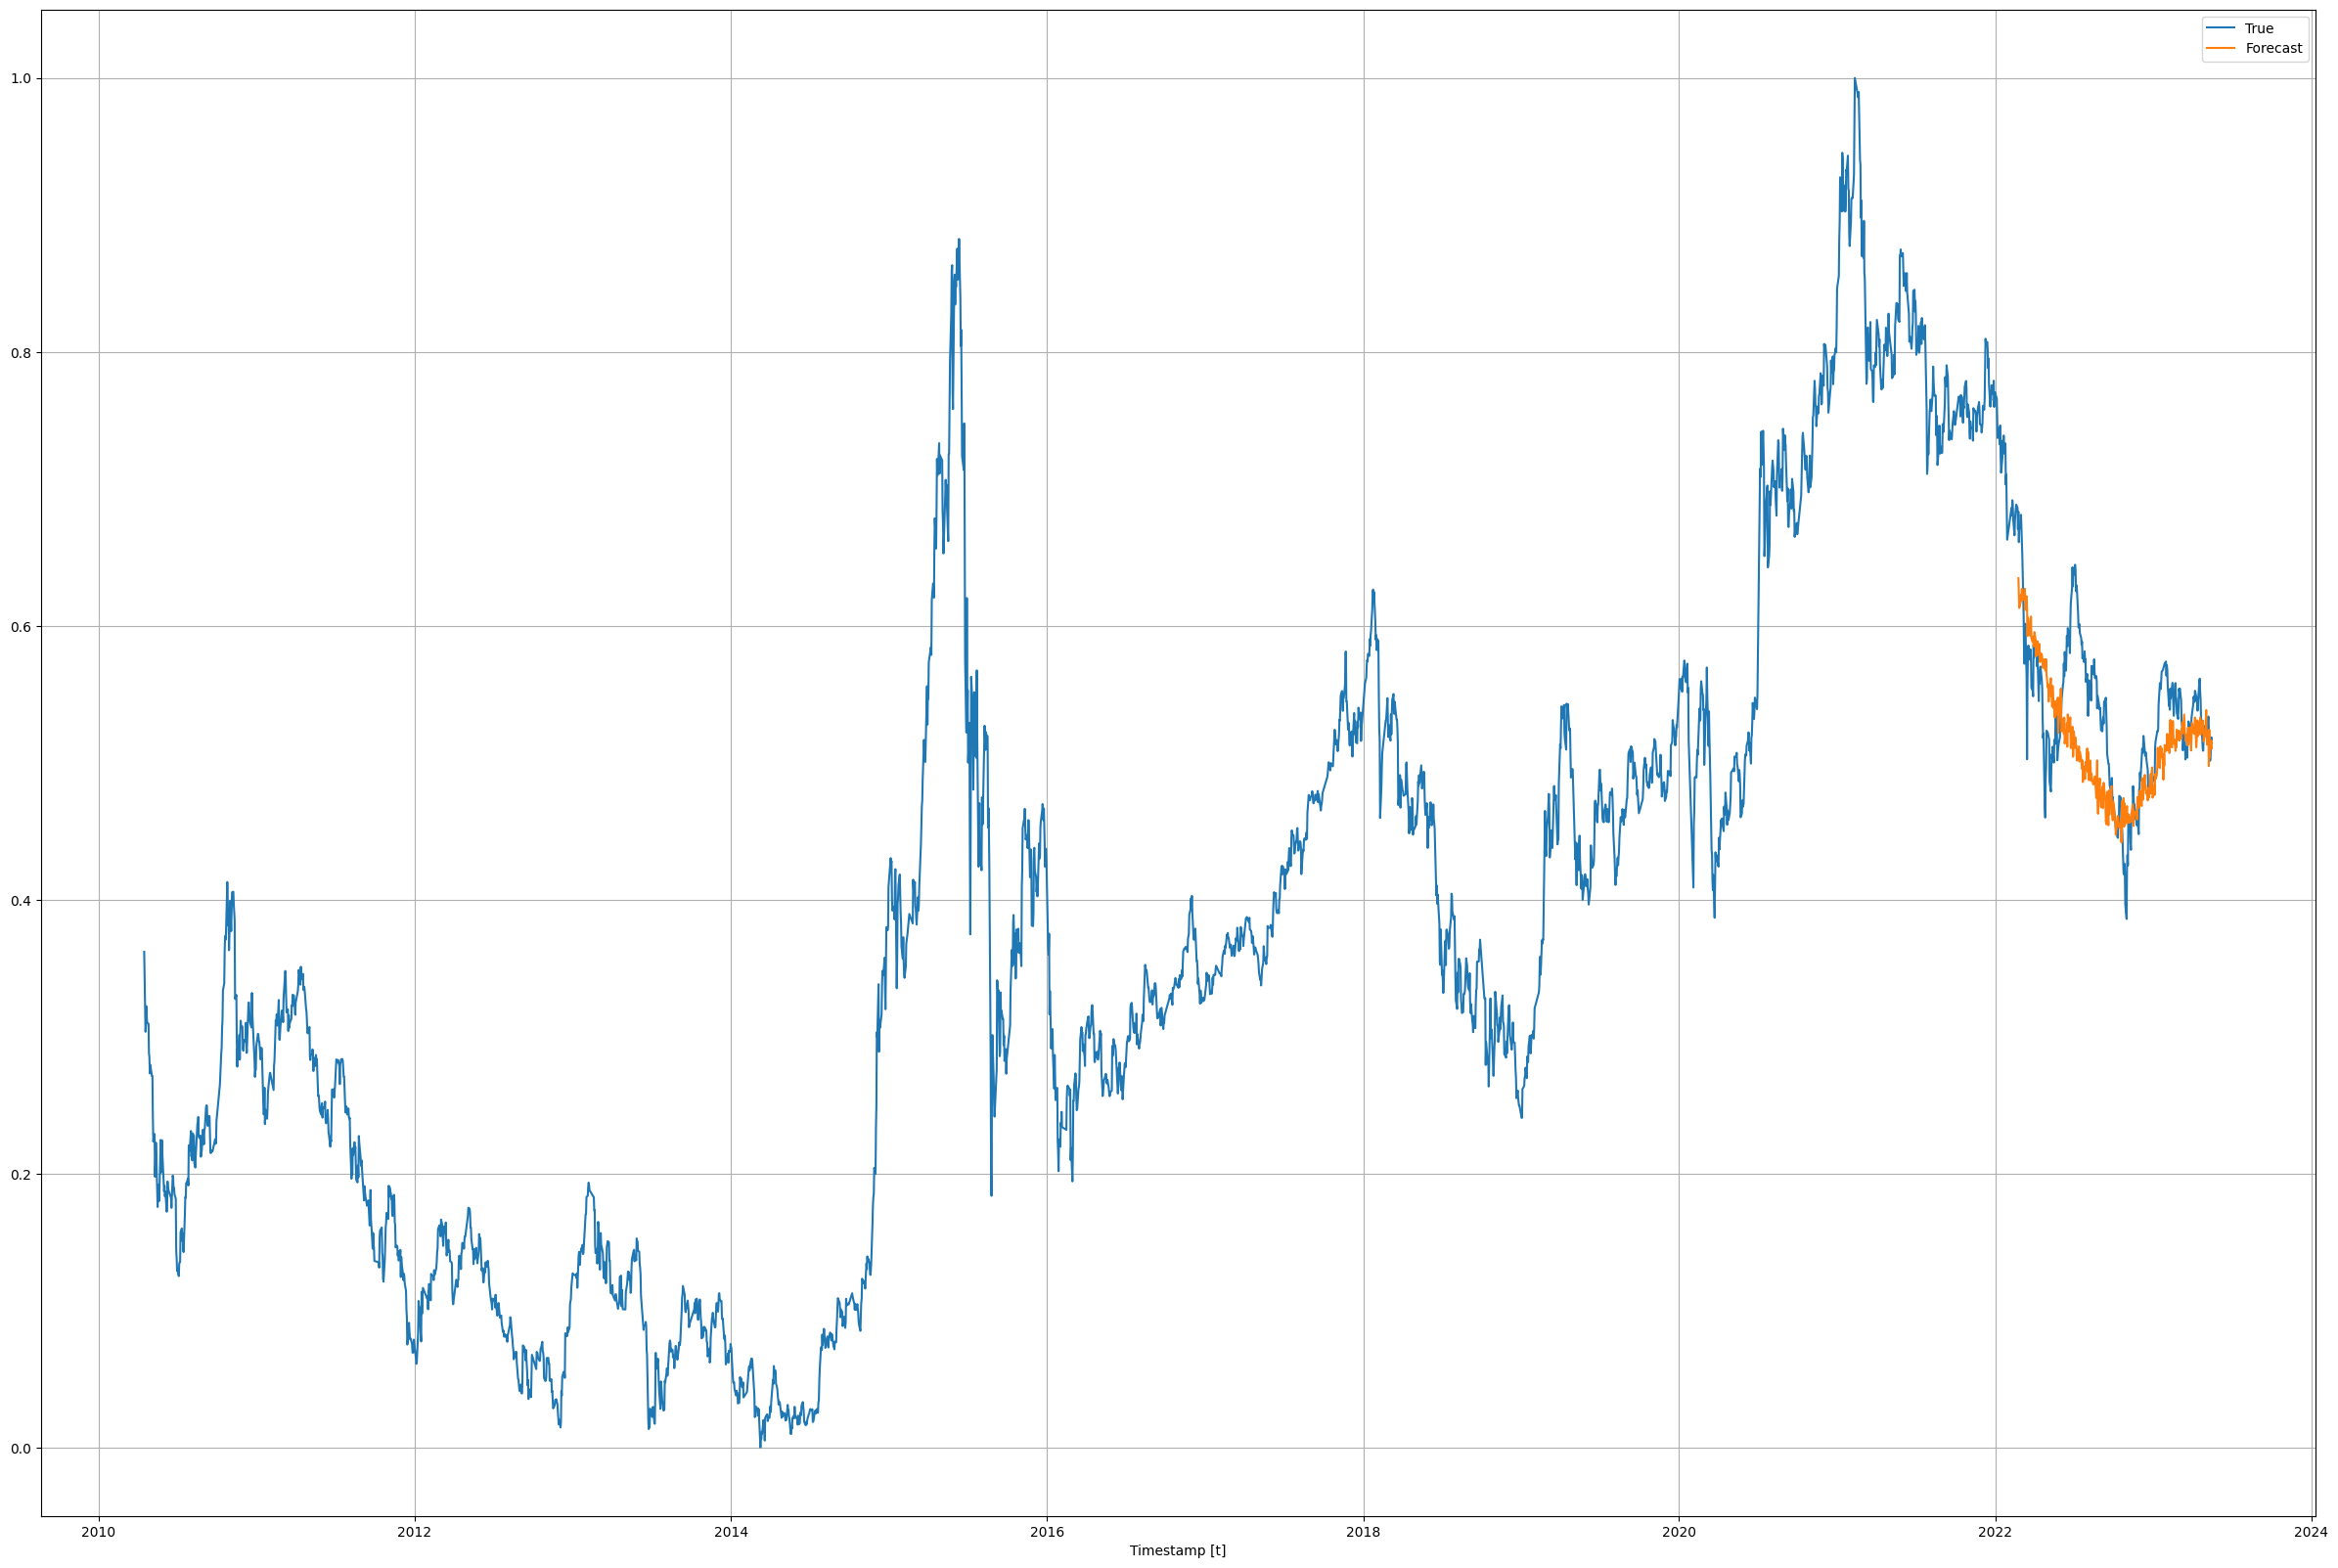

In [10]:
Y_hat = nf1.predict(futr_df=X_test)

print(Y_hat)

"""
画图
"""
Y_hat = Y_hat.merge(X_test, how='left', on=['unique_id', 'ds'])
Y_hat = Y_hat.interpolate().dropna()

# Plot predictions
plt.figure(figsize=(30, 20))
plot_df = pd.concat([X_train, Y_hat]).set_index('ds')
plt.plot(plot_df['y'], label='True')
plt.plot(plot_df['NBEATSx'], label='Forecast')
plt.xlabel('Timestamp [t]')
plt.ylabel('')
plt.grid()
plt.legend()
plt.savefig("N-BEATSx.png")

In [11]:
calculate_evaluation(y_test=X_test['y'], y_pred=Y_hat['NBEATSx'])

Mean Squared Error: 0.002345549672217271, Mean Absolute Error: 0.03896849381977426
r2 score: 0.14007573510878946
MAPE: 7.198528286607285
RMSE: 0.048430875195656656


2880 320 320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.58it/s] 


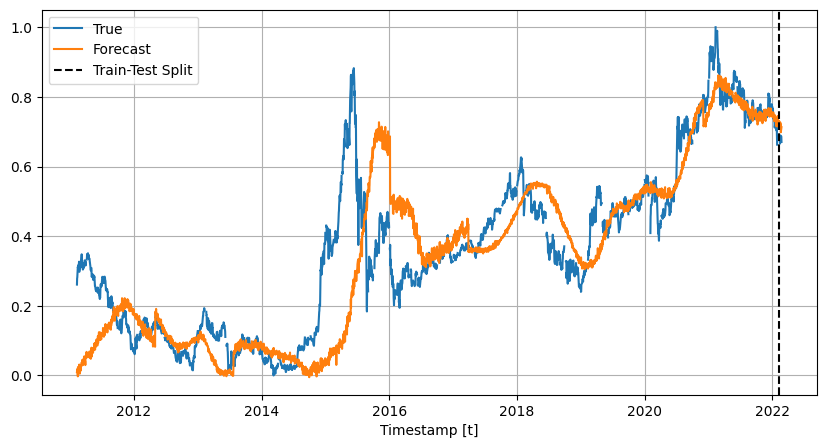

In [12]:
# insample_prediction
Y_hat_insample = nf1.predict_insample(step_size=len(X_test))
plt.figure(figsize=(10, 5))
plt.plot(Y_hat_insample['ds'], Y_hat_insample['y'], label='True')
plt.plot(Y_hat_insample['ds'], Y_hat_insample['NBEATSx'], label='Forecast')
plt.axvline(Y_hat_insample['ds'].iloc[-12], color='black', linestyle='--', label='Train-Test Split')
plt.xlabel('Timestamp [t]')
plt.ylabel('')
plt.grid()
plt.legend()

# MLP

In [13]:
model = MLP(h=len(X_test), input_size=INPUT_SIZE, max_steps=MAX_STEP)
nf3 = NeuralForecast(models=[model], freq='B')
nf3.fit(df=X_train)
Y_hat = nf3.predict(futr_df=X_test)
print(Y_hat)


Global seed set to 1


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s, v_num=1850, train_loss_step=0.103, train_loss_epoch=0.103]  
                  ds
unique_id           
IF00      2022-02-23
IF00      2022-02-24
IF00      2022-02-25
IF00      2022-02-28
IF00      2022-03-01
...              ...
IF00      2023-05-10
IF00      2023-05-11
IF00      2023-05-12
IF00      2023-05-15
IF00      2023-05-16

[320 rows x 1 columns]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.67it/s]
                  ds       MLP
unique_id                     
IF00      2022-02-23  0.685046
IF00      2022-02-24  0.682594
IF00      2022-02-25  0.676768
IF00      2022-02-28  0.678115
IF00      2022-03-01  0.687077
...              ...       ...
IF00      2023-05-10  0.651466
IF00      2023-05-11  0.648891
IF00      2023-05-12  0.656476
IF00      2023-05-15  0.646823
IF00      2023-05-16  0.649838

[320 rows x 2 columns]


Mean Squared Error: 0.02147252714321457, Mean Absolute Error: 0.1373329902999453
r2 score: -6.872247319124327
MAPE: 27.081351540729987
RMSE: 0.14653507137615407


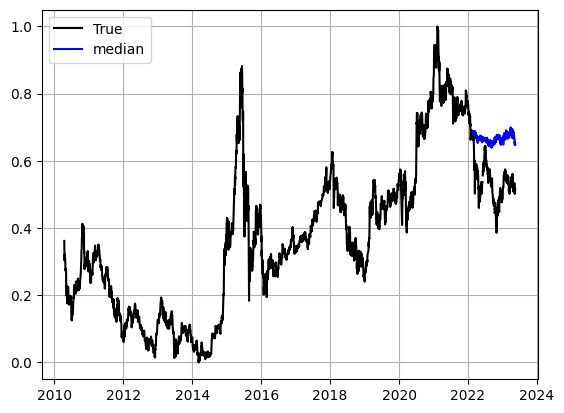

In [14]:
Y_hat = Y_hat.merge(X_test, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([X_train, Y_hat])
plot_df = plot_df.drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['MLP'], c='blue', label='median')
plt.grid()
plt.legend()
plt.plot()

calculate_evaluation(y_test=X_test['y'], y_pred=Y_hat['MLP'])

# LSTM

In [15]:
# """
# 读数据
# """
# # X = load_groups_n()
# # X_cur = X[X['unique_id']==TARGET_DATA].reset_index(drop=True)
# # # X_test = X_cur[TRAIN_NUM:]
# # # X_train = X_cur[:TRAIN_NUM]
# # X_train = X_cur[:int(len(X_cur) * TRAIN_TEST_RATIO)]
# # X_test = X_cur[int(len(X_cur) * TRAIN_TEST_RATIO):]
# # print(len(X_train), len(X_test))
# nf2 = NeuralForecast(
#     models=[LSTM(h=len(X_test), 
#                 futr_exog_list=['KPJ', 'QSPJ','ZGJ', 'ZDJ', 'CJL', 'CJE', ],
                
#                 )
#     ],
#     freq='B' # 'D'
# )

# nf2.fit(df=X_train)
# nf2.save(path='./checkpoints/lstm_run/',
#         model_index=None, 
#         overwrite=True,
#         save_dataset=True)
# nf2 = NeuralForecast.load(path='./checkpoints/lstm_run/')
# Y_hat = nf2.predict(futr_df=X_test)
# # Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])

# Y_hat = Y_hat.merge(X_test, how='left', on=['unique_id', 'ds'])
# print(Y_hat)

# Y_hat = Y_hat.interpolate().dropna()

# # Plot predictions
# plt.figure(figsize=(30, 20))
# plot_df = pd.concat([X_train, Y_hat]).set_index('ds')
# plt.plot(plot_df['y'], label='True')
# plt.plot(plot_df['LSTM'], label='Forecast')
# # plt.plot(Y_hat_insample['ds'], Y_hat_insample['y'], label='True')
# # plt.plot(Y_hat_insample['ds'], Y_hat_insample['NBEATSx'], label='Forecast')
# # plt.axvline(Y_hat_insample['ds'].iloc[-12], color='black', linestyle='--', label='Train-Test Split')
# plt.xlabel('Timestamp [t]')
# plt.ylabel('')
# plt.grid()
# plt.legend()
# plt.savefig("LSTM.png")

# calculate_evaluation(X_test['y'], Y_hat['LSTM'])

# SVM

In [16]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import os

In [17]:
# X = load_groups_n()
# X = X[X['unique_id']==TARGET_DATA].reset_index(drop=True)
# X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])
# X = X.dropna()
# X, y = X[['KPJ', 'QSPJ','ZGJ', 'ZDJ', 'CJL', 'CJE']], X[['y']]
# X_train = X[:int(len(X) * TRAIN_TEST_RATIO)]
# X_test = X[int(len(X) * TRAIN_TEST_RATIO):]
# y_train = y[:int(len(X) * TRAIN_TEST_RATIO)]
# y_test = y[int(len(X) * TRAIN_TEST_RATIO):]

In [18]:
# svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# svr_model.fit(X_train, y_train)

# y_pred = svr_model.predict(X_test)

# print(y_test, y_pred)

# plt_true = pd.concat([y_train, y_test])

# pred_df = pd.DataFrame(y_pred, columns=['pred'])
# plt_pred = pd.concat([X_train, pred_df], ignore_index=True)

# plt.figure(figsize=(30, 20))
# plt.plot(plt_true['y'], label='True Values')
# plt.plot(plt_pred['pred'], label='Predicted Values')

# plt.legend()
# plt.xlabel('Sample Index')
# plt.ylabel('Value')
# plt.title('True vs. Predicted Values')
# plt.show()

# calculate_evaluation(y_test['y'], pd.DataFrame(y_pred))

# ARIMA

In [19]:
X = load_groups_n()
X = add_macro_economy_data(X, CPI_file_path, GDP_file_path, use_linear_transform=False)
X = X[X['unique_id']==TARGET_DATA].reset_index(drop=True)
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])
X = X.dropna()
X_train = X[:int(len(X) * TRAIN_TEST_RATIO)]
X_test = X[int(len(X) * TRAIN_TEST_RATIO):]
print(X)

     unique_id         ds         y       KPJ      QSPJ       ZGJ       ZDJ  \
0         IF00 2010-04-16  0.361885  0.358364  0.361725  0.362749  0.380456   
1         IF00 2010-04-19  0.303515  0.344372  0.361885  0.339251  0.314148   
2         IF00 2010-04-20  0.308116  0.295968  0.303515  0.298000  0.314846   
3         IF00 2010-04-21  0.322187  0.297471  0.308116  0.308757  0.325369   
4         IF00 2010-04-22  0.313894  0.309183  0.322187  0.306981  0.326174   
...        ...        ...       ...       ...       ...       ...       ...   
3195      IF00 2023-06-09  0.473490  0.454136  0.467658  0.453606  0.486550   
3196      IF00 2023-06-12  0.473704  0.454343  0.473490  0.459349  0.487732   
3197      IF00 2023-06-13  0.481462  0.456571  0.473704  0.461960  0.491812   
3198      IF00 2023-06-14  0.480927  0.467351  0.481462  0.467495  0.499919   
3199      IF00 2023-06-15  0.497940  0.467973  0.480927  0.477051  0.502658   

           CJL       CJE       CPI       PPI      G

/home/arthur/.conda/envs/neuralforecast/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


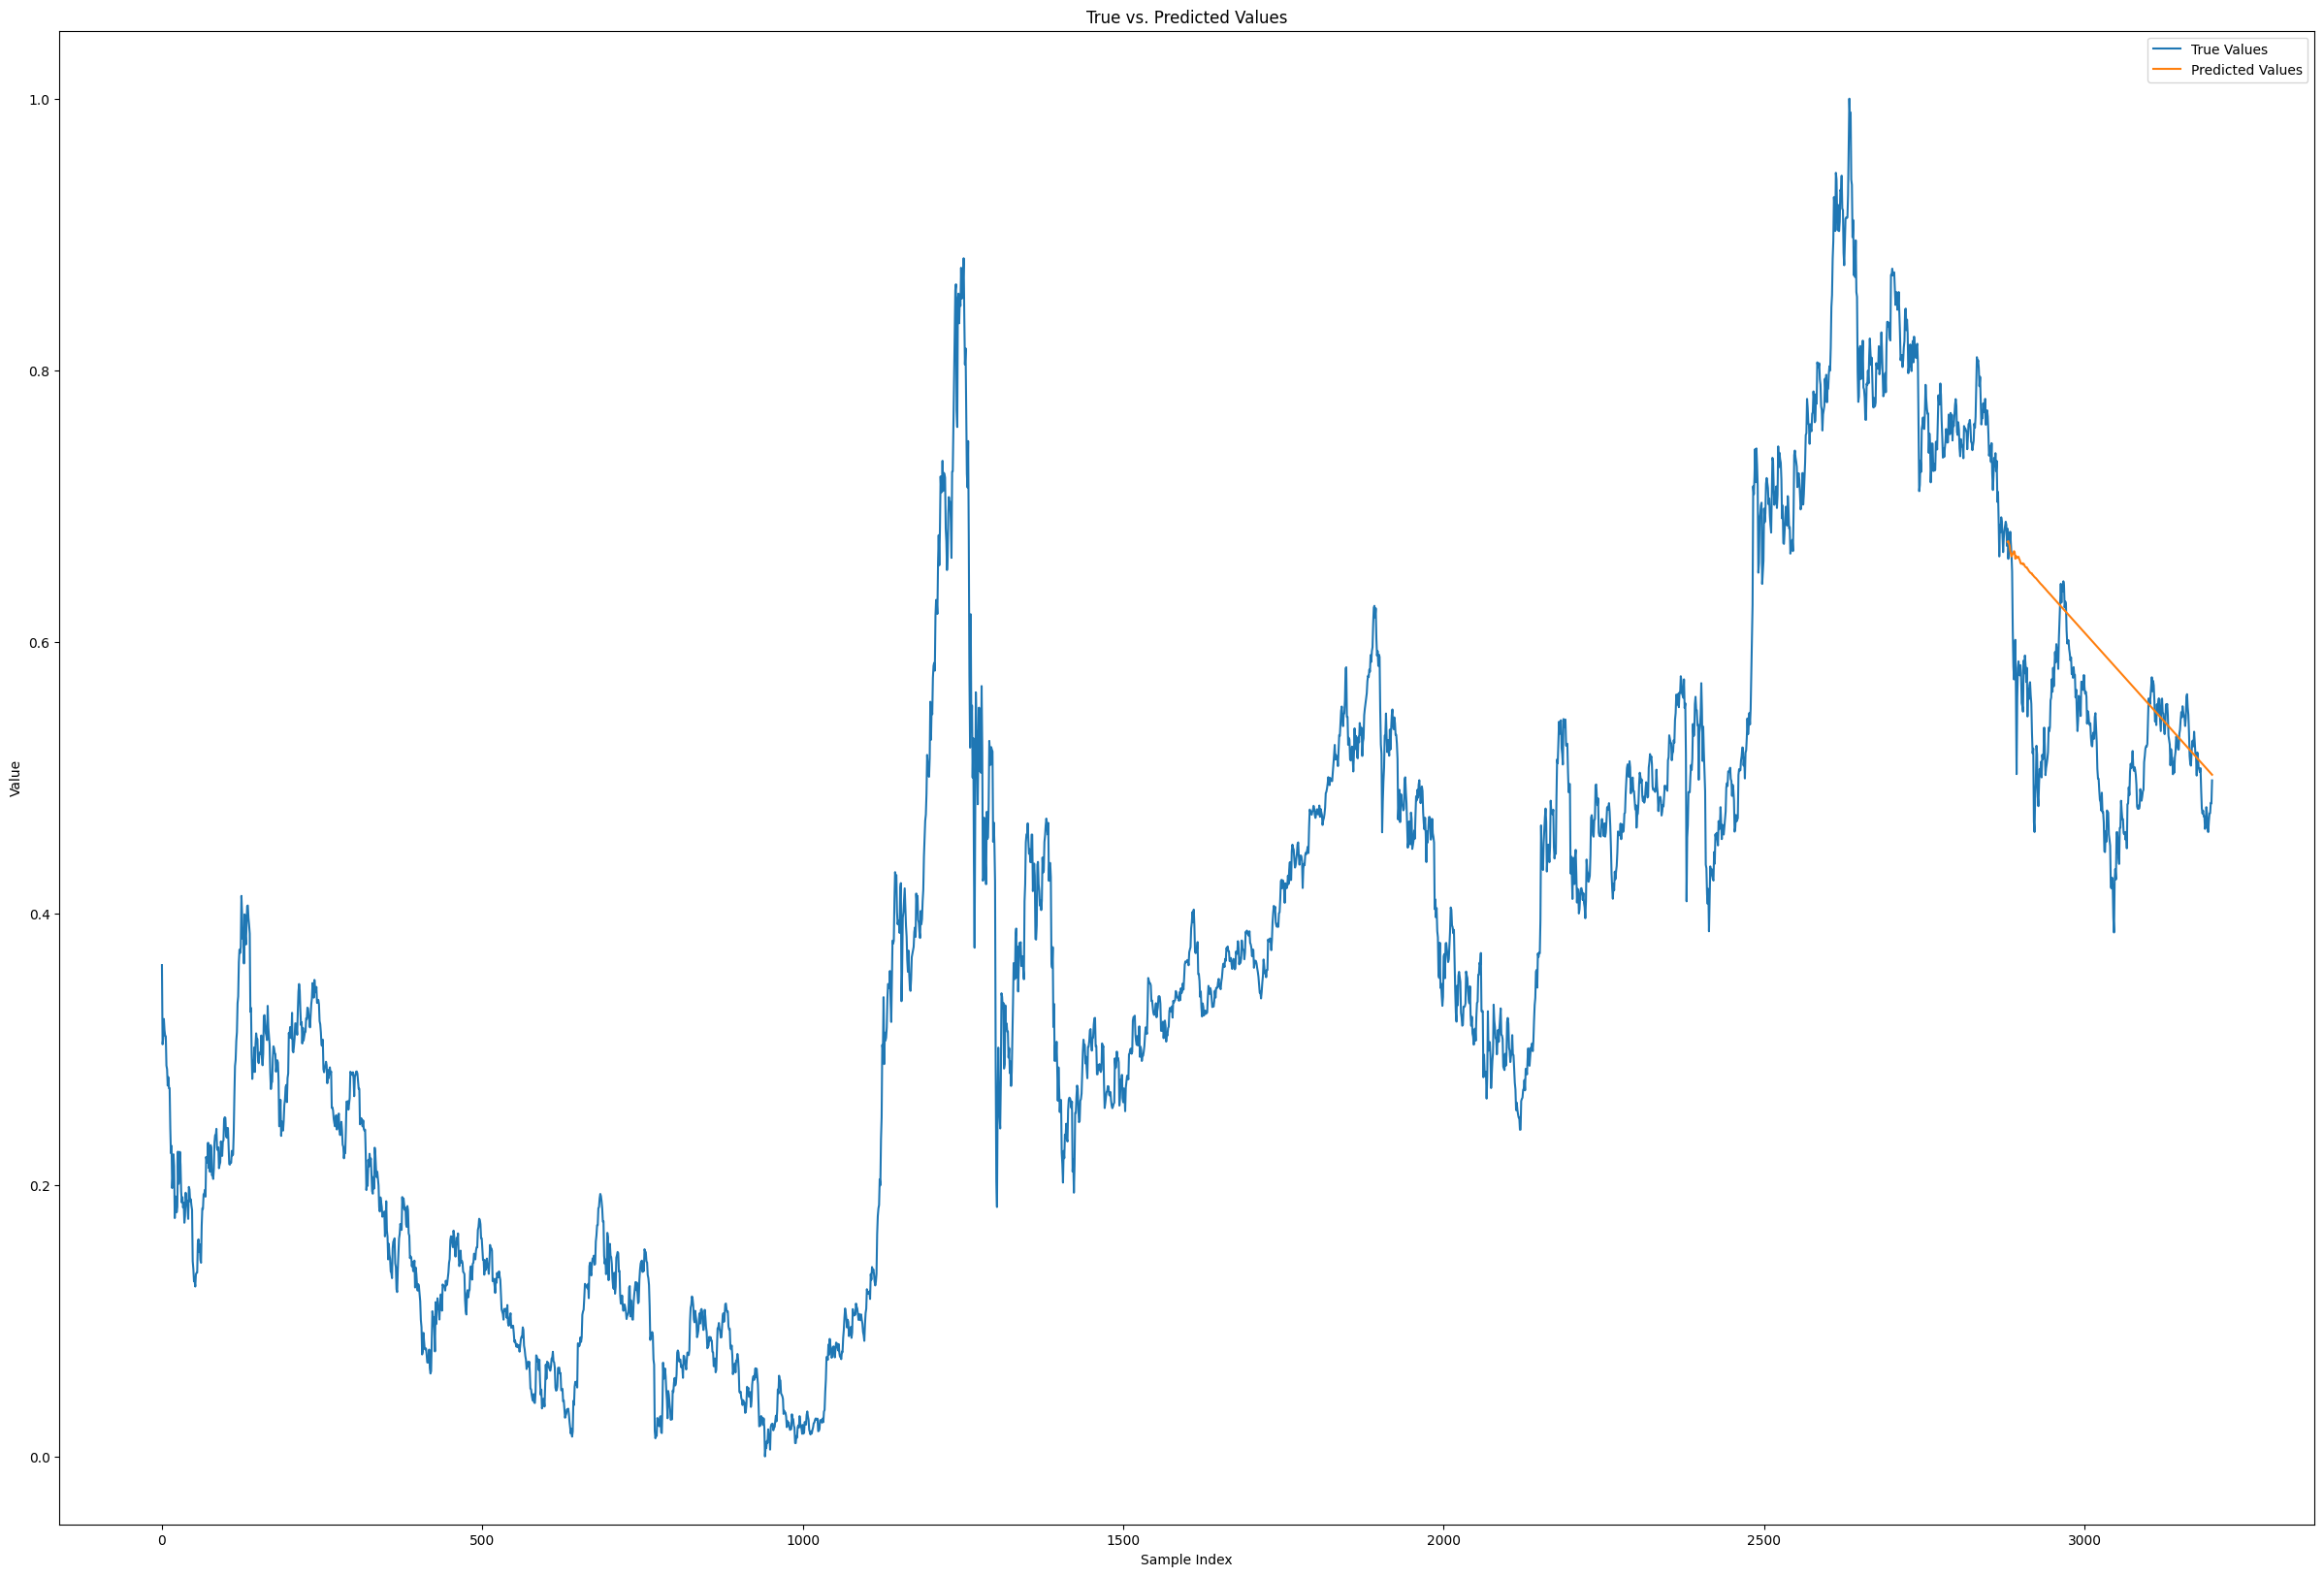

Mean Squared Error: 0.005955892397704865, Mean Absolute Error: 0.06046001650235876
r2 score: -1.183546335655297
MAPE: 100.0
RMSE: 0.07717442839247249


In [25]:
p, d, q = INPUT_SIZE, 2, INPUT_SIZE  # ARIMA(p, d, q) 参数
model = ARIMA(X_train['y'], order=(p, d, q))
results = model.fit()
y_pred = results.forecast(steps=len(X_test)).to_list()

plt_true = pd.concat([X['y']])
pred_df = pd.DataFrame(y_pred, columns=['pred'])
plt_pred = pd.concat([X_train, pred_df], ignore_index=True)

plt.figure(figsize=(30, 20))
plt.plot(plt_true, label='True Values')
plt.plot(plt_pred['pred'], label='Predicted Values')

plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs. Predicted Values')
plt.show()

calculate_evaluation(X_test['y'], pd.DataFrame(y_pred))